In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from financepy.utils import *
from financepy.products.bonds import *
from financepy.market.curves import *

In [ ]:
# --- Bond Characteristics ---
# Define the bond's maturity date
maturity_dt = Date(1, 1, 2046)
# Annual coupon rate
coupon = 0.05
# Coupon payment frequency
freq_type = FrequencyTypes.SEMI_ANNUAL
# Day count convention for accrual
accrualBasis = DayCountTypes.ACT_365F

# Date when conversion feature starts
start_convert_dt = Date(1, 1, 2026)

# Bond's face value
face = 100

# Ratio of shares received per bond upon conversion

conversion_ratio = 0.2 # I essentially assumed a 20% conversion premium

# --- Call Provision Details ---
# Define the years the call option can be exercised
call_start_year = 2036
call_end_year = 2046
# Generate the specific exercise dates for the call option
call_dts_scaled = [Date(1,1,year) for year in range(call_start_year, call_end_year + 1)]

# Starting price at which the bond can be called
initial_scaled_call_price = 115
# Annual decrement in the call price
scaled_decrement = 1

# Calculate the call price for each exercise date
call_prices_scaled = [initial_scaled_call_price - (scaled_decrement * j)
                      for j in range(len(call_dts_scaled))]

# --- Put Provision Details ---
# Define the years the put option can be exercised by the holder
put_start_year = 2026
put_end_year = 2036
# Generate the specific exercise dates for the put option
put_dts_scaled = [Date(1,1,year) for year in range(put_start_year, put_end_year + 1)]

# Price at which the bond can be put back to the issuer
scaled_put_price = 100
# Put price is constant across all exercise dates
put_prices_scaled = [scaled_put_price for _ in range(len(put_dts_scaled))]

# --- Create Bond Object ---
# Instantiate the convertible bond object with all its features
bond = BondConvertible(maturity_dt, coupon, freq_type, start_convert_dt, conversion_ratio,
                       call_dts_scaled, call_prices_scaled,
                       put_dts_scaled, put_prices_scaled, accrualBasis)

# --- Valuation Inputs ---
# Set the valuation date
settle_dt = Date(1, 7, 2025)

# Define dividend schedule (excluding the settlement date)
dividendSchedule = Schedule(settle_dt, maturity_dt).schedule_dts()[1:]
# Assign a constant dividend yield for each dividend date
dividend_yields = [0.0076] * len(dividendSchedule)

# Current stock price
stock_price = 417
# Volatility of the underlying stock
stock_volatility = 0.22
# Risk-free interest rate
rate = 0.0475
# Create a flat discount curve from the risk-free rate
discount_curve = DiscountCurveFlat(settle_dt, rate, FrequencyTypes.ANNUAL)

# Issuer's credit spread
credit_spread = 0.0025
# Expected recovery rate in case of default
recovery_rate = 0.5

# --- Valuation Calculation ---
# Define an observed decrease in stock price
observed_stock_price_decrease_pct = 0.0459
# Calculate an adjusted stock price based on the observed decrease
adjusted_stock_price = stock_price * (1.0 - observed_stock_price_decrease_pct)

# Calculate the theoretical value of the bond using the initial stock price
theoretical_value = bond.value(settle_dt, stock_price, stock_volatility, dividendSchedule, dividend_yields,
                               discount_curve, credit_spread, recovery_rate)

# Calculate the theoretical value of the bond using the adjusted stock price
adjusted_value = bond.value(settle_dt, adjusted_stock_price, stock_volatility, dividendSchedule, dividend_yields,
                             discount_curve, credit_spread, recovery_rate)

In [35]:
theoretical_value

{'cbprice': np.float64(129.57589130691719),
 'bond': np.float64(99.85383888293448),
 'delta': np.float64(0.1393669209988186),
 'gamma': np.float64(0.0017921346362913641),
 'theta': np.float64(33.10253559068528)}

In [36]:
adjusted_value

{'cbprice': np.float64(127.08584180206154),
 'bond': np.float64(99.85383888293448),
 'delta': np.float64(0.1353940025151008),
 'gamma': np.float64(0.002021001291590884),
 'theta': np.float64(31.065307766378893)}


--- Stock Volatility Sensitivity ---
Volatility CB Price
-------------
0.1000 119.3979
0.1500 123.8422
0.2000 128.0747
0.2500 132.0817
0.3000 136.0740
0.3500 139.8837
0.4000 143.3690
0.4500 146.7886
0.5000 150.1746


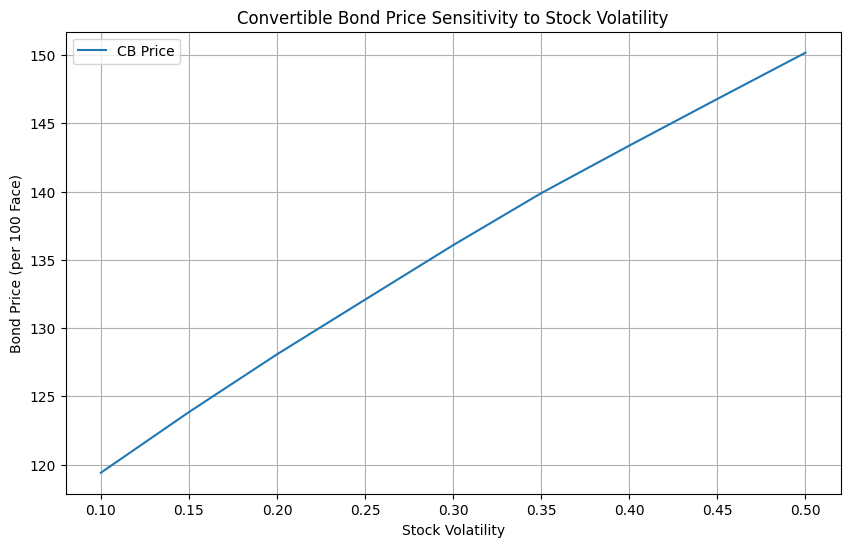


--- Interest Rate Sensitivity ---
Rate CB Price Bond Floor
------------------------
0.0200 150.6564 142.7356
0.0250 146.5028 133.3014
0.0300 142.6715 124.6804
0.0350 138.7075 116.7946
0.0400 134.7222 109.5738
0.0450 131.1837 102.9552
0.0500 128.0726 96.8823
0.0550 125.4956 91.3043
0.0600 123.4161 86.1754
0.0650 121.6256 81.4545
0.0700 120.0342 77.1045
0.0750 118.6086 73.0920
0.0800 117.3216 69.3867


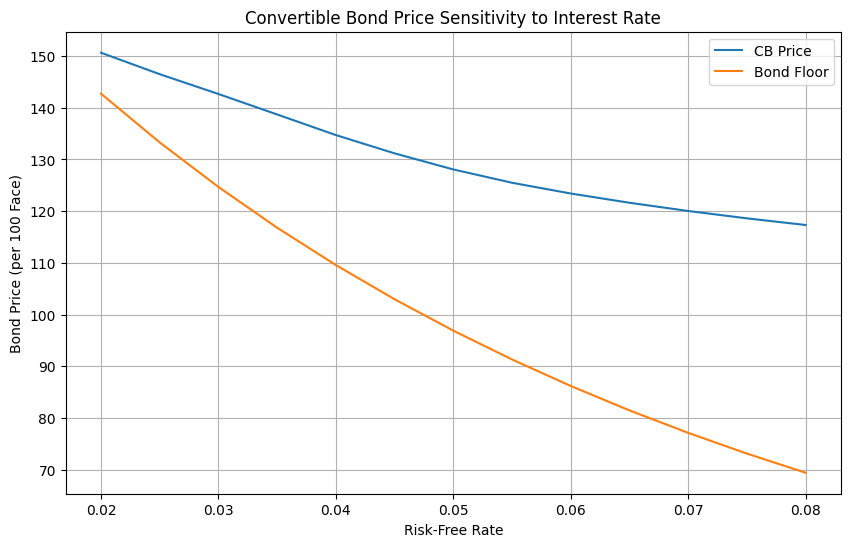


--- Credit Spread Sensitivity ---
Spread CB Price Bond Floor
------------------------
0.0010 131.1190 102.5271
0.0029 129.6461 99.9832
0.0048 128.3946 97.5979
0.0067 127.2975 95.3602
0.0086 126.2807 93.2601
0.0105 125.4304 91.2885
0.0124 124.7626 89.4365
0.0143 124.1863 87.6962
0.0162 123.8795 86.0601
0.0181 123.6953 84.5211
0.0200 123.7668 83.0729


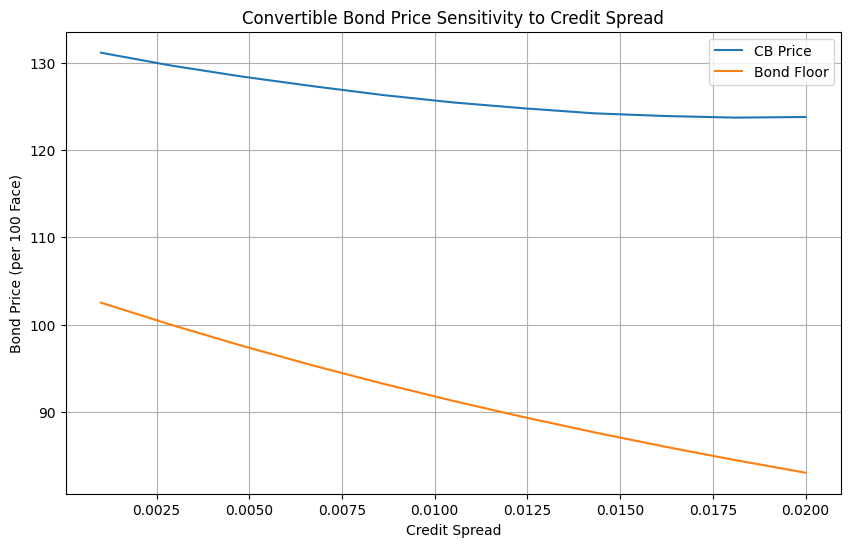

In [37]:

# --- Stock Volatility Sensitivity ---
print("\n--- Stock Volatility Sensitivity ---") # Header

# Define range of volatilities
vols = np.linspace(0.1, 0.5, 9) # From 10% to 100%

# List to store resulting bond prices
cb_for_vols = []

print("Volatility CB Price") # Table header
print("-------------") # Separator

# Loop through each volatility
for v in vols:
    # Calculate bond value using current volatility
    res = bond.value(settle_dt, stock_price, v, dividendSchedule, dividend_yields,
                     discount_curve, credit_spread, recovery_rate)

    # Get the convertible bond price
    price_val = res['cbprice']

    # Store the price
    cb_for_vols.append(price_val)

    # Print volatility and price
    print(f"{v:.4f} {price_val:.4f}")

# Plotting volatility sensitivity
plt.figure(figsize=(10, 6)) # Create figure
plt.plot(vols, cb_for_vols, label='CB Price') # Plot data
plt.xlabel("Stock Volatility") # X-axis label
plt.ylabel("Bond Price (per 100 Face)") # Y-axis label
plt.title("Convertible Bond Price Sensitivity to Stock Volatility") # Plot title
plt.legend() # Show legend
plt.grid(True) # Add grid
plt.show() # Display plot


# --- Interest Rate Sensitivity ---
print("\n--- Interest Rate Sensitivity ---") # Header

# Define range of interest rates
rates = np.linspace(0.02, 0.08, 13) # From 2% to 8%

# Lists to store results
cb_for_rates = []
floors_for_rates = [] # Store bond floor as well

print("Rate CB Price Bond Floor") # Table header
print("------------------------") # Separator

# Loop through each rate
for current_rate in rates:
    # Create a new discount curve for the current rate
    new_curve = DiscountCurveFlat(settle_dt, current_rate, FrequencyTypes.ANNUAL)

    # Calculate bond value using the new rate
    res = bond.value(settle_dt, stock_price, stock_volatility, dividendSchedule, dividend_yields,
                     new_curve, credit_spread, recovery_rate)

    # Get prices
    cb_val = res['cbprice']
    floor_val = res['bond'] # This is the bond floor

    # Store prices
    cb_for_rates.append(cb_val)
    floors_for_rates.append(floor_val)

    # Print rate, CB price, and Bond Floor
    print(f"{current_rate:.4f} {cb_val:.4f} {floor_val:.4f}")

# Plotting interest rate sensitivity
plt.figure(figsize=(10, 6)) # Create figure
plt.plot(rates, cb_for_rates, label='CB Price') # Plot CB price
plt.plot(rates, floors_for_rates, label='Bond Floor') # Plot Bond Floor
plt.xlabel("Risk-Free Rate") # X-axis label
plt.ylabel("Bond Price (per 100 Face)") # Y-axis label
plt.title("Convertible Bond Price Sensitivity to Interest Rate") # Plot title
plt.legend() # Show legend
plt.grid(True) # Add grid
plt.show() # Display plot


# --- Credit Spread Sensitivity ---
print("\n--- Credit Spread Sensitivity ---") # Header

# Define range of credit spreads
spreads = np.linspace(0.001, 0.02, 11) # From 10 bps to 200 bps

# Lists to store results
cb_for_spreads = []
floors_for_spreads = [] # Spread affects bond floor

print("Spread CB Price Bond Floor") # Table header
print("------------------------") # Separator

# Loop through each spread
for current_spread in spreads:
    # Calculate bond value using the current spread
    res = bond.value(settle_dt, stock_price, stock_volatility, dividendSchedule, dividend_yields,
                     discount_curve, current_spread, recovery_rate)

    # Get prices
    cb_s_val = res['cbprice']
    floor_s_val = res['bond'] # This is the bond floor

    # Store prices
    cb_for_spreads.append(cb_s_val)
    floors_for_spreads.append(floor_s_val)

    # Print spread, CB price, and Bond Floor
    print(f"{current_spread:.4f} {cb_s_val:.4f} {floor_s_val:.4f}")

# Plotting credit spread sensitivity
plt.figure(figsize=(10, 6)) # Create figure
plt.plot(spreads, cb_for_spreads, label='CB Price') # Plot CB price
plt.plot(spreads, floors_for_spreads, label='Bond Floor') # Plot Bond Floor
plt.xlabel("Credit Spread") # X-axis label
plt.ylabel("Bond Price (per 100 Face)") # Y-axis label
plt.title("Convertible Bond Price Sensitivity to Credit Spread") # Plot title
plt.legend() # Show legend
plt.grid(True) # Add grid
plt.show() # Display plot
